# Item Sales Prediction

## Common Imports

In [1]:
%load_ext dotenv
%dotenv

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import opendatasets as od 
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures)
from xgboost import XGBRegressor

## Data

### Load the data from Kaggle

In [3]:
KAGGLE_USER=os.getenv("KAGGLE_USER_NAME")
KAGGLE_API=os.getenv("KAGGLE_API_KEY")

In [4]:
od.download("https://www.kaggle.com/datasets/shivan118/big-mart-sales-prediction-datasets/train.csv")

Skipping, found downloaded files in "./big-mart-sales-prediction-datasets" (use force=True to force download)


In [5]:
#dataset = pd.read_csv("big-sales-prediction-dataset/Big Sales Data.csv")
dataset = pd.read_csv("big-mart-sales-prediction-datasets/train.csv")
dataset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Data Exploration

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
dataset.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
dataset.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
# create a copy to perform data transformations
data = dataset.copy(deep=True)

#### Target Column: Item_Outlet_Sales

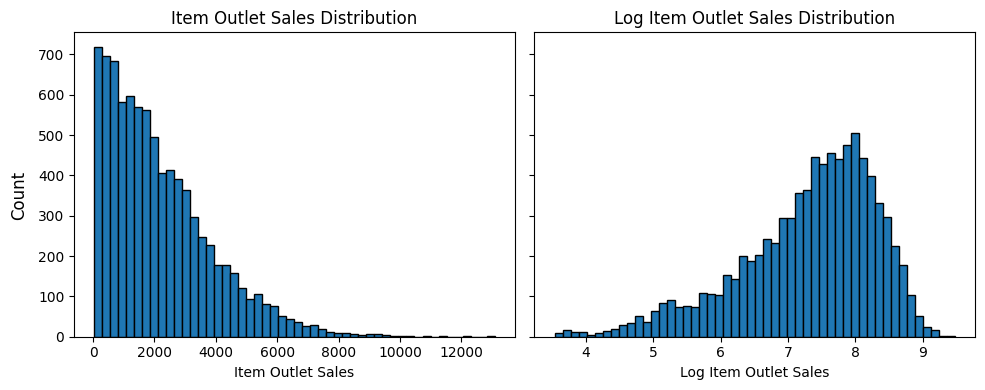

In [10]:
# apply log transformation on the target feature
data["Item_Outlet_Sales_log"] = data["Item_Outlet_Sales"].apply(np.log1p)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax[0].hist(data["Item_Outlet_Sales"], bins=50, edgecolor="black")
ax[1].hist(data["Item_Outlet_Sales_log"], bins=50, edgecolor="black")
ax[0].set_title("Item Outlet Sales Distribution")
ax[1].set_title("Log Item Outlet Sales Distribution")
ax[0].set_xlabel("Item Outlet Sales")
ax[1].set_xlabel("Log Item Outlet Sales")
fig.supylabel("Count")
plt.tight_layout()
plt.show()

#### Item_Identifier

In [11]:
item_ids = data.loc[:, "Item_Identifier"].unique()
print("Number of unique item identifiers:", len(item_ids))
print("Item identifiers sample:\n", item_ids[:30])

Number of unique item identifiers: 1559
Item identifiers sample:
 ['FDA15' 'DRC01' 'FDN15' 'FDX07' 'NCD19' 'FDP36' 'FDO10' 'FDP10' 'FDH17'
 'FDU28' 'FDY07' 'FDA03' 'FDX32' 'FDS46' 'FDF32' 'FDP49' 'NCB42' 'DRI11'
 'FDU02' 'FDN22' 'FDW12' 'NCB30' 'FDC37' 'FDR28' 'NCD06' 'FDV10' 'DRJ59'
 'FDE51' 'FDC14' 'FDV38']


In [12]:
# group items by first 3 letters in order to reduce the number of categories
grouped = data["Item_Identifier"].groupby(data['Item_Identifier'].str[:3])
# add new column
data["Item_Identifier_trunc"] = data["Item_Identifier"].str[:3]
grouped.nunique()

Item_Identifier
DRA     3
DRB     5
DRC     8
DRD    10
DRE    11
       ..
NCV    10
NCW    10
NCX    10
NCY    10
NCZ    10
Name: Item_Identifier, Length: 71, dtype: int64

In [13]:
# average sales by group
data.groupby(["Item_Identifier_trunc"])["Item_Outlet_Sales"].agg("mean").to_dict()

{'DRA': 2271.455961904762,
 'DRB': 1729.21576,
 'DRC': 2023.3302108108107,
 'DRD': 1778.1615714285715,
 'DRE': 2033.0619125,
 'DRF': 2092.87572,
 'DRG': 2174.417197142857,
 'DRH': 1154.2820953846156,
 'DRI': 2169.8324088235295,
 'DRJ': 2288.7462470588234,
 'DRK': 2047.0424515151517,
 'DRL': 1764.156944,
 'DRM': 2703.612511627907,
 'DRN': 1770.7734294117647,
 'DRO': 1673.5358571428571,
 'DRP': 2710.4718,
 'DRQ': 2600.6148,
 'DRY': 504.2325333333333,
 'DRZ': 2144.4812727272724,
 'FDA': 2356.9754808163266,
 'FDB': 2411.201493877551,
 'FDC': 2064.177611872146,
 'FDD': 2353.7801394495414,
 'FDE': 1977.4494201005025,
 'FDF': 2594.7510284263963,
 'FDG': 2065.2897192488263,
 'FDH': 1826.316270852018,
 'FDI': 2614.8519310679612,
 'FDJ': 2278.765707216495,
 'FDK': 2460.2339256038645,
 'FDL': 1981.6708657276995,
 'FDM': 2059.4896329545454,
 'FDN': 2381.9948532663316,
 'FDO': 2120.330111587983,
 'FDP': 2144.956464912281,
 'FDQ': 2152.1280522821576,
 'FDR': 2402.4049294545457,
 'FDS': 2087.42141003

#### Item_Weight

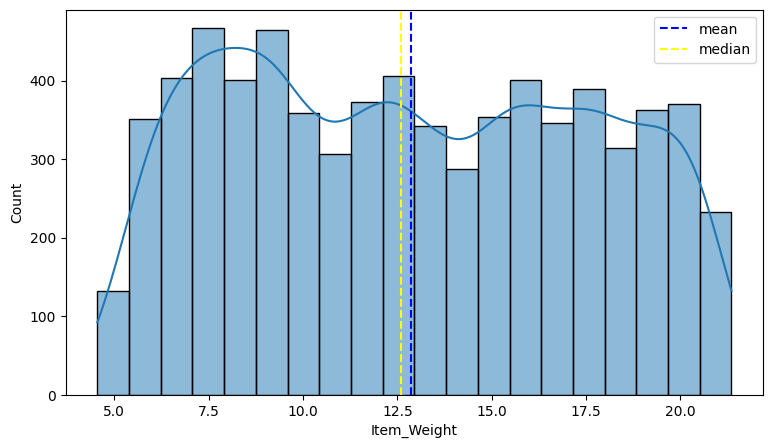

In [14]:
plt.figure(figsize=(9, 5))
sns.histplot(data, x="Item_Weight", kde=True)
plt.axvline(data["Item_Weight"].mean(), color="b", linestyle="--", label="mean")
plt.axvline(data["Item_Weight"].median(), color="yellow", linestyle="--", label="median")
plt.legend()
plt.show()

In [15]:
# column contains missing values
data.loc[data["Item_Weight"].isna()].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Outlet_Sales_log
count,0.0,1463.000000,1463.000000,1463.0,1463.000000,1463.000000
mean,NaN,0.076597,139.796485,1985.0,2483.677474,7.136826
std,NaN,0.063012,61.617672,0.0,2347.516621,1.376405
min,NaN,0.000000,31.290000,1985.0,33.955800,3.554084
25%,NaN,0.029545,92.630400,1985.0,399.480000,5.992664
50%,NaN,0.060588,143.781200,1985.0,1845.597600,7.521100
75%,NaN,0.110718,184.426600,1985.0,3968.168000,8.286306
max,NaN,0.328391,266.588400,1985.0,13086.964800,9.479448


Statistic shows that the missing item weight values are from year 1985

In [16]:
year_1985 = data.loc[data["Outlet_Establishment_Year"] == 1985]
year_1985

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Outlet_Sales_log,Item_Identifier_trunc
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,8.299973,FDP
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680,7.742692,DRI
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432,8.310180,FDW
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876,5.372439,FDC
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362,4.842896,FDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490,8.742390,DRK
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150,8.321741,DRG
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120,7.922048,NCN
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656,6.191064,FDU


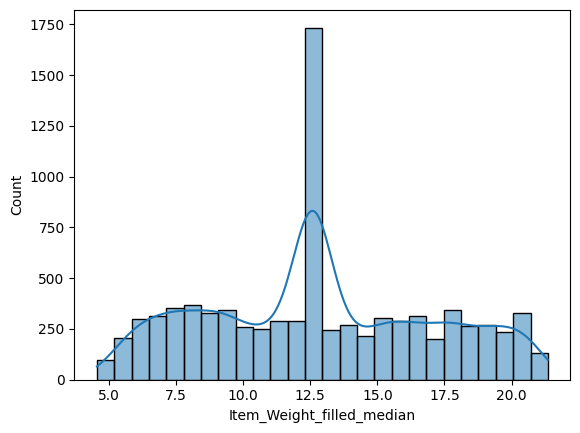

In [17]:
# fill NaNs weights with weights median value which is closer to the peak
data["Item_Weight_filled_median"] = data["Item_Weight"].fillna(data["Item_Weight"].median())
# plot hte resulting distribution
sns.histplot(data, x="Item_Weight_filled_median", kde=True)
plt.show()

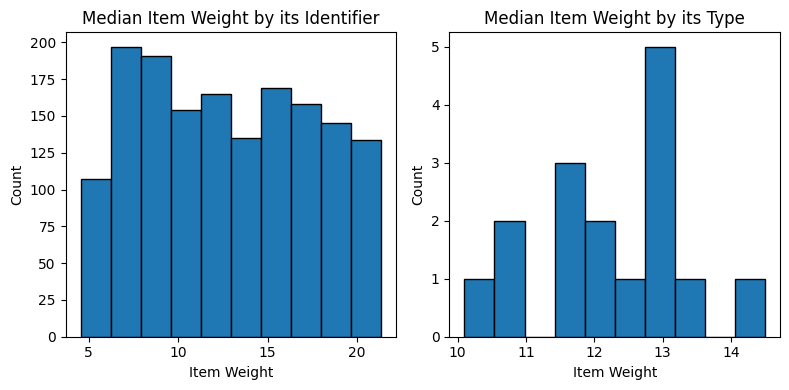

In [18]:
# compute median and mean item weights by item identifier and item type 
fillna_id = data.groupby("Item_Identifier")["Item_Weight"].agg(["mean", "median"]).to_dict()
fillna_type = data.groupby("Item_Type")["Item_Weight"].agg(["mean", "median"]).to_dict()
# items median weights distribution grouped by item identifier
# apply log transformation to the target feature
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(fillna_id["median"].values(), edgecolor="black")
ax[1].hist(fillna_type["median"].values(), edgecolor="black")
ax[0].set_title("Median Item Weight by its Identifier")
ax[1].set_title("Median Item Weight by its Type")
ax[0].set_xlabel("Item Weight")
ax[1].set_xlabel("Item Weight")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [19]:
data["Item_Weight_filled_by_type"] = data["Item_Weight"].fillna(data["Item_Type"].map(fillna_type["median"]))
data["Item_Weight_filled_by_id"] = data["Item_Weight"].fillna(data["Item_Identifier"].map(fillna_id["median"]))

In [20]:
# correlation between imputed item weights and target variable
data[["Item_Weight", "Item_Weight_filled_median", "Item_Weight_filled_by_id", "Item_Weight_filled_by_type", "Item_Outlet_Sales", "Item_Outlet_Sales_log"]].corr()

,Item_Weight,Item_Weight_filled_median,Item_Weight_filled_by_id,Item_Weight_filled_by_type,Item_Outlet_Sales,Item_Outlet_Sales_log
Item_Weight,1.000000,1.000000,1.000000,1.000000,0.014123,0.009776
Item_Weight_filled_median,1.000000,1.000000,0.909388,0.996666,0.009693,0.009716
Item_Weight_filled_by_id,1.000000,0.909388,1.000000,0.910570,0.013168,0.007677
Item_Weight_filled_by_type,1.000000,0.996666,0.910570,1.000000,0.010188,0.009128
Item_Outlet_Sales,0.014123,0.009693,0.013168,0.010188,1.000000,0.861762
Item_Outlet_Sales_log,0.009776,0.009716,0.007677,0.009128,0.861762,1.000000


#### Item_Fat_Content

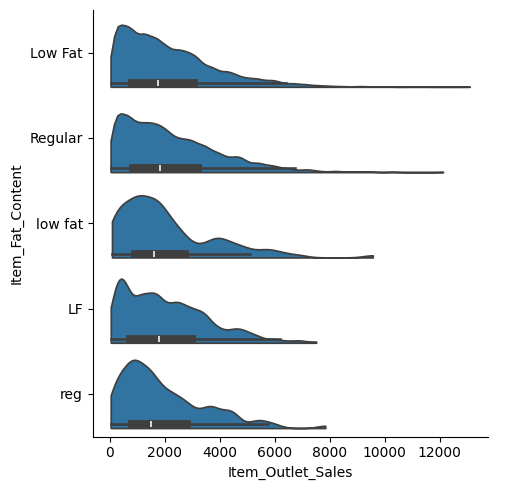

In [21]:
sns.catplot(y="Item_Fat_Content", x="Item_Outlet_Sales", kind="violin", bw_adjust=.5, cut=0, split=True, data=data)
plt.show()

In [22]:
# replace fat content category for non-consumable products
data.loc[(data["Item_Identifier"].str[:2] == "NC"), "Item_Fat_Content"] = "Non-Consumable"

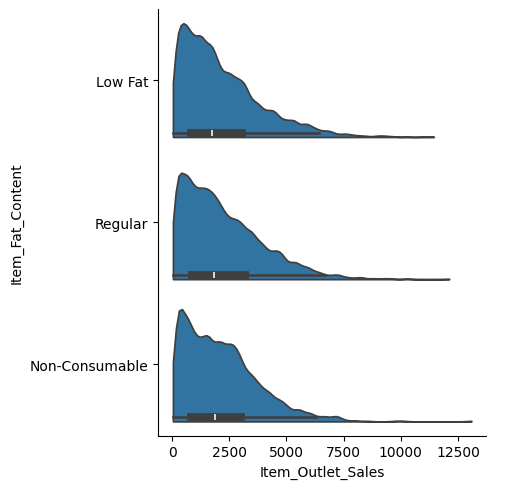

In [23]:
# update other fat content categories to ensure consistency
data["Item_Fat_Content"] = data.loc[:, "Item_Fat_Content"].replace({"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"})
sns.catplot(y="Item_Fat_Content", x="Item_Outlet_Sales", kind="violin", bw_adjust=.5, cut=0, split=True, data=data)
plt.show()

#### Item_Visibility

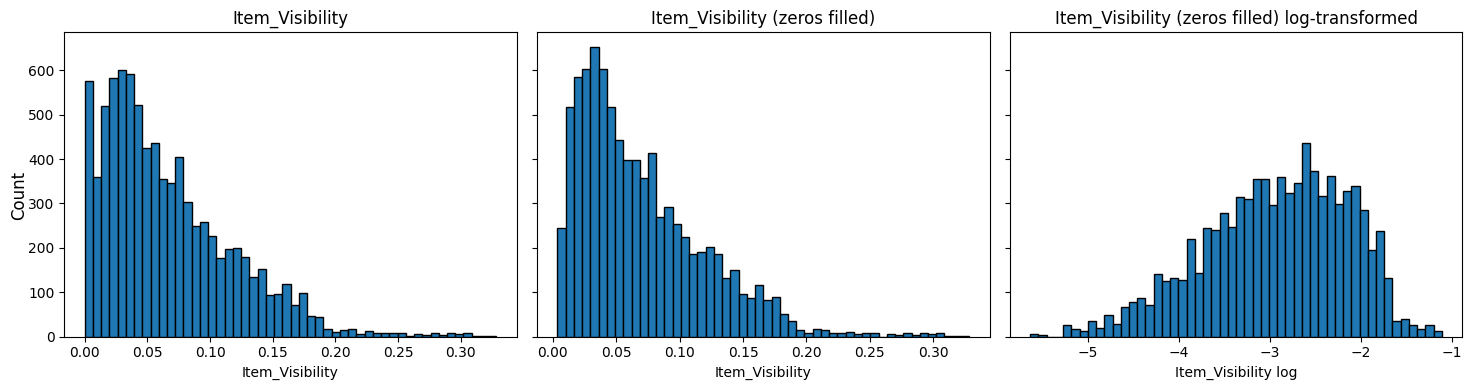

In [24]:
# replace zeros visibility values by mean value of the corresponding item identifier group
fill_dict = data.groupby("Item_Identifier")["Item_Visibility"].agg(["mean"]).to_dict()
data["Item_Visibility_nozeros"] = np.where(data["Item_Visibility"] == 0.0, np.nan, data["Item_Visibility"])
data["Item_Visibility_nozeros"] = data["Item_Visibility_nozeros"].fillna(data["Item_Identifier"].map(fill_dict["mean"]))
data["Item_Visibility_nozeros_log"] = data["Item_Visibility_nozeros"].map(np.log)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
ax[0].hist(data["Item_Visibility"], bins=50, edgecolor="black")
ax[1].hist(data["Item_Visibility_nozeros"], bins=50, edgecolor="black")
ax[2].hist(data["Item_Visibility_nozeros_log"], bins=50, edgecolor="black")
ax[0].set_title("Item_Visibility")
ax[1].set_title("Item_Visibility (zeros filled)")
ax[2].set_title("Item_Visibility (zeros filled) log-transformed")
ax[0].set_xlabel("Item_Visibility")
ax[1].set_xlabel("Item_Visibility")
ax[2].set_xlabel("Item_Visibility log")
fig.supylabel("Count")
plt.tight_layout()
plt.show()

#### Item_Type

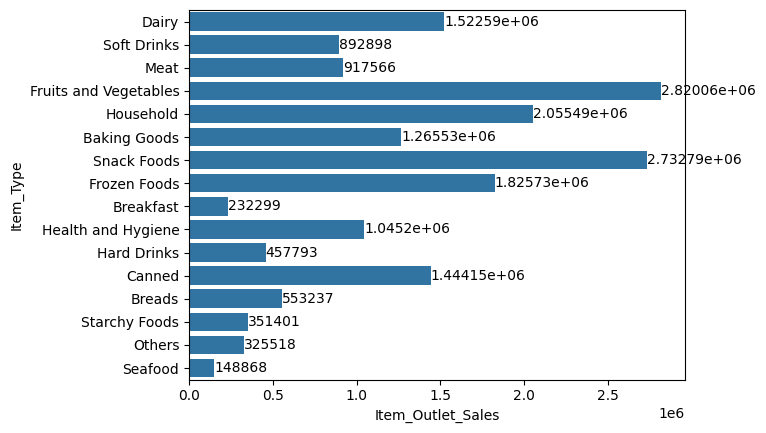

In [25]:
ax = sns.barplot(data, x="Item_Outlet_Sales", y="Item_Type", estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);

#### Item_MRP

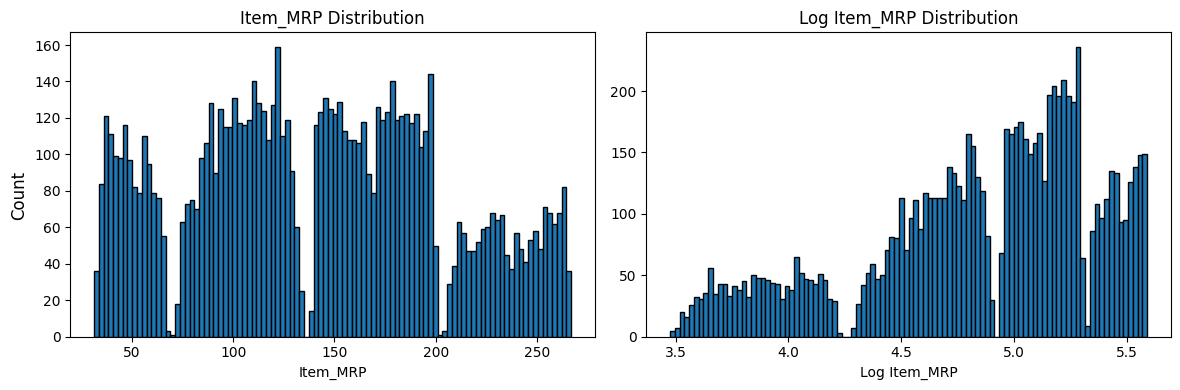

In [26]:
data["Item_MRP_log"] = data["Item_MRP"].map(np.log1p)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(data["Item_MRP"], bins=100, edgecolor="black")
ax[1].hist(data["Item_MRP_log"], bins=100, edgecolor="black")
ax[0].set_title("Item_MRP Distribution")
ax[1].set_title("Log Item_MRP Distribution")
ax[0].set_xlabel("Item_MRP")
ax[1].set_xlabel("Log Item_MRP")
fig.supylabel("Count")
plt.tight_layout()
plt.show()

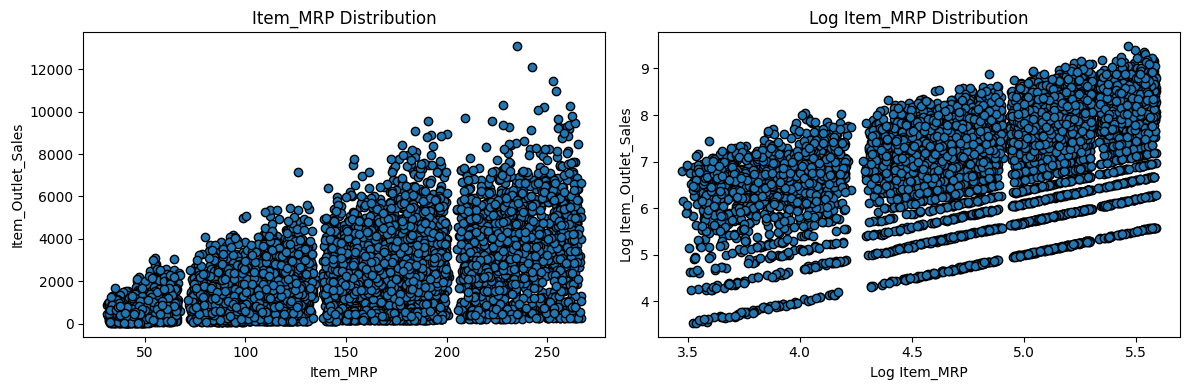

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(data["Item_MRP"], data["Item_Outlet_Sales"], edgecolor="black")
ax[1].scatter(data["Item_MRP_log"], data["Item_Outlet_Sales_log"], edgecolor="black")
ax[0].set_title("Item_MRP Distribution")
ax[1].set_title("Log Item_MRP Distribution")
ax[0].set_xlabel("Item_MRP")
ax[1].set_xlabel("Log Item_MRP")
ax[0].set_ylabel("Item_Outlet_Sales")
ax[1].set_ylabel("Log Item_Outlet_Sales")
plt.tight_layout()
plt.show()

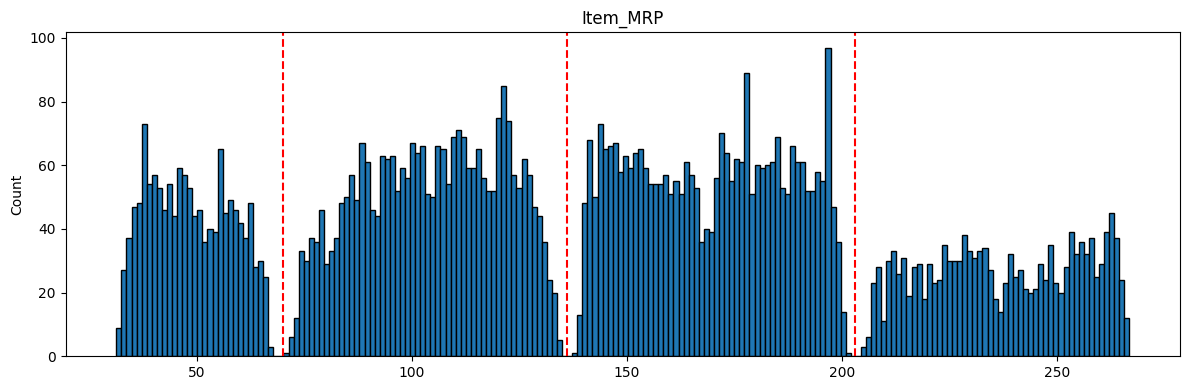

In [28]:
plt.figure(figsize=(12, 4))
plt.hist(data["Item_MRP"], bins=200, edgecolor="black")
plt.axvline(70, color="r", linestyle="--", label="70")
plt.axvline(136, color="r", linestyle="--", label="70")
plt.axvline(203, color="r", linestyle="--", label="70")
plt.title("Item_MRP")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

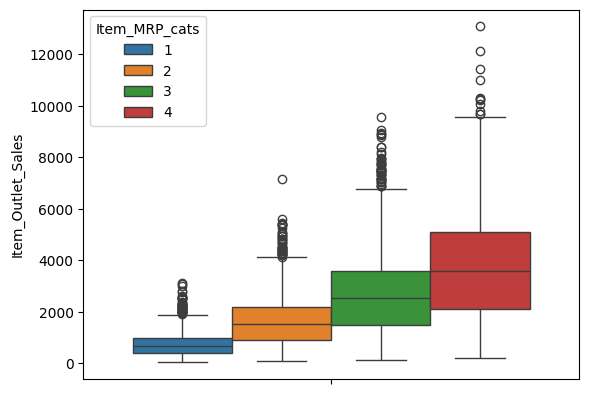

In [29]:
# create MPR categories
data["Item_MRP_cats"] = pd.cut(data.loc[:, "Item_MRP"], bins=[0, 70, 136, 203, 300], labels=[1, 2, 3, 4])
sns.boxplot(data, y="Item_Outlet_Sales", hue="Item_MRP_cats")
plt.show()

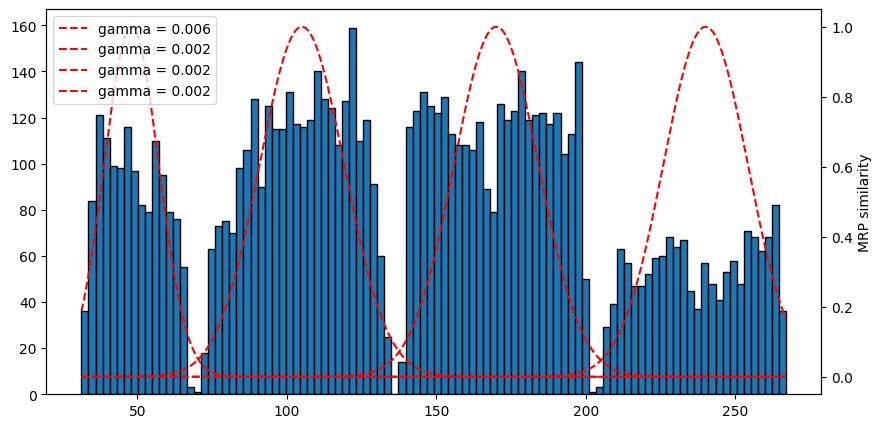

In [30]:
# transform Item_MRP using RBF kernels
from sklearn.metrics.pairwise import rbf_kernel

mrps = np.linspace(data["Item_MRP"].min(),
                   data["Item_MRP"].max(),
                   500).reshape(-1, 1)

simil_48 = rbf_kernel(mrps, [[48]], gamma=0.006)
simil_103 = rbf_kernel(mrps, [[105]], gamma=0.0025)
simil_165 = rbf_kernel(mrps, [[170]], gamma=0.0025)
simil_240 = rbf_kernel(mrps, [[240]], gamma=0.0025)

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.hist(data["Item_MRP"], bins=100, edgecolor="black")

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "black"
ax2.plot(mrps, simil_48, color="r", label="gamma = 0.006", linestyle="--")
ax2.plot(mrps, simil_103, color="r", label="gamma = 0.002", linestyle="--")
ax2.plot(mrps, simil_165, color="r", label="gamma = 0.002", linestyle="--")
ax2.plot(mrps, simil_240, color="r", label="gamma = 0.002", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("MRP similarity", color=color)

plt.legend(loc="upper left")
plt.show()

In [31]:
# add new features to the data
data[["MRP48_simil"]] = rbf_kernel(data[["Item_MRP"]], [[48]], gamma=0.006)
data[["MRP103_simil"]] = rbf_kernel(data[["Item_MRP"]], [[103]], gamma=0.0025)
data[["MRP170_simil"]] = rbf_kernel(data[["Item_MRP"]], [[170]], gamma=0.0025)
data[["MRP240_simil"]] = rbf_kernel(data[["Item_MRP"]], [[240]], gamma=0.0025)

data[["MRP48_simil", "MRP103_simil", "MRP170_simil", "MRP240_simil", "Item_Outlet_Sales_log", "Item_Outlet_Sales"]].corr()

,MRP48_simil,MRP103_simil,MRP170_simil,MRP240_simil,Item_Outlet_Sales_log,Item_Outlet_Sales
MRP48_simil,1.000000,-0.237413,-0.245438,-0.155365,-0.393941,-0.340008
MRP103_simil,-0.237413,1.000000,-0.370484,-0.236849,-0.111550,-0.205369
MRP170_simil,-0.245438,-0.370484,1.000000,-0.239519,0.191276,0.172225
MRP240_simil,-0.155365,-0.236849,-0.239519,1.000000,0.260333,0.355236
Item_Outlet_Sales_log,-0.393941,-0.111550,0.191276,0.260333,1.000000,0.861762
Item_Outlet_Sales,-0.340008,-0.205369,0.172225,0.355236,0.861762,1.000000


#### Outlet_Identifier

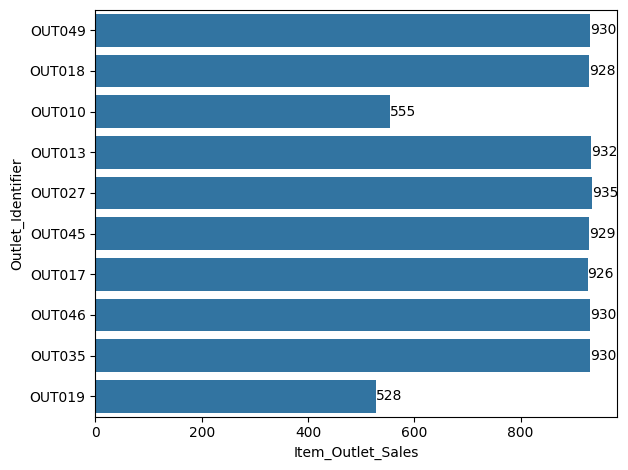

In [32]:
ax = sns.barplot(data, x="Item_Outlet_Sales", y="Outlet_Identifier", estimator="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);
plt.tight_layout()
plt.show()

#### Outlet_Establishment_Year

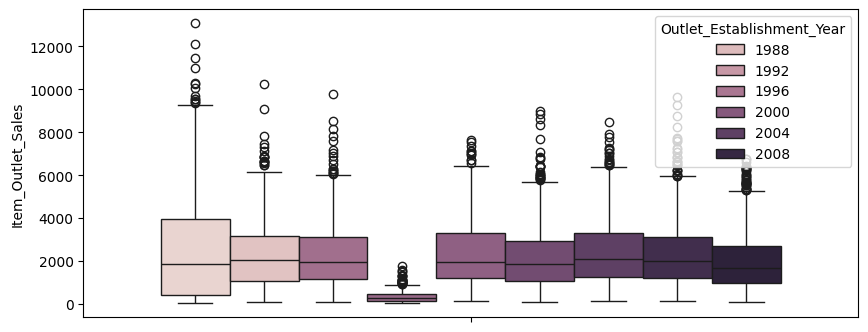

In [33]:
plt.figure(figsize=(10, 4))
sns.boxplot(hue="Outlet_Establishment_Year", y="Item_Outlet_Sales", data=data)
plt.show()

#### Outlet_Size

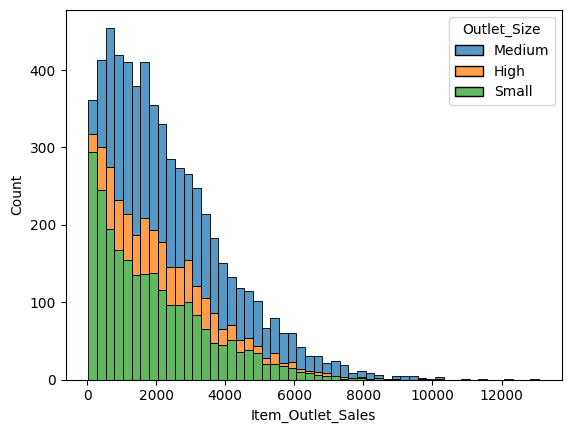

In [34]:
sns.histplot(x="Item_Outlet_Sales", hue="Outlet_Size", multiple="stack", data=data)
plt.show()

In [35]:
# missing values statistics
size_nans = data.loc[data["Outlet_Size"].isna()]
size_nans.loc[:, ["Item_Weight", "Item_Visibility", "Item_MRP", "Outlet_Establishment_Year", "Item_Outlet_Sales"]].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000
mean,12.778479,0.070259,140.322946,2003.000000,1822.626947
std,4.589825,0.055029,62.397904,3.506502,1557.858015
min,4.590000,0.000000,32.090000,1998.000000,33.290000
25%,8.785000,0.028744,93.096200,2002.000000,554.777850
50%,12.600000,0.056414,142.165400,2002.000000,1443.454400
75%,16.700000,0.100364,185.135800,2007.000000,2681.509500
max,21.350000,0.311090,266.888400,2007.000000,9664.752800


In [36]:
# dictionary to replace missing values: if there are multiple modes, take the first value, 
# if the identifier has no mode (unique value) -> replace with "Medium"
grouped_mode = data.groupby('Item_Identifier')['Outlet_Size'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "Medium").to_dict()
# number of keys in the dictionary
len(grouped_mode.keys())

1559

In [37]:
print("Missing otlet size values count:", data["Outlet_Size"].isna().sum())
data["Outlet_Size_filled_mode"] = data["Outlet_Size"].fillna(data["Item_Identifier"].map(grouped_mode))
print("Missing otlet size values count (after imputation):", data["Outlet_Size_filled_mode"].isna().sum())

Missing otlet size values count: 2410
Missing otlet size values count (after imputation): 0


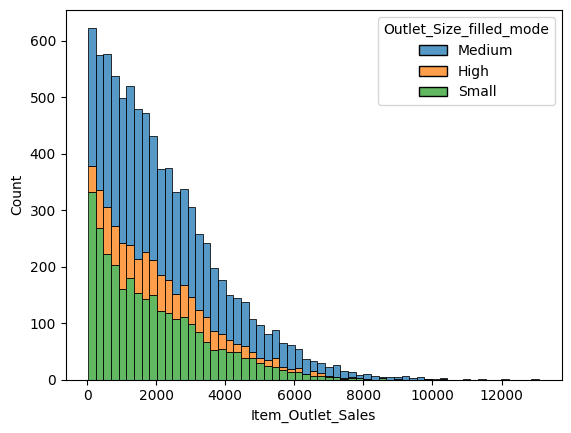

In [38]:
# after imputation
sns.histplot(x="Item_Outlet_Sales", hue="Outlet_Size_filled_mode", multiple="stack", data=data)
plt.show()

#### Outlet_Location_Type

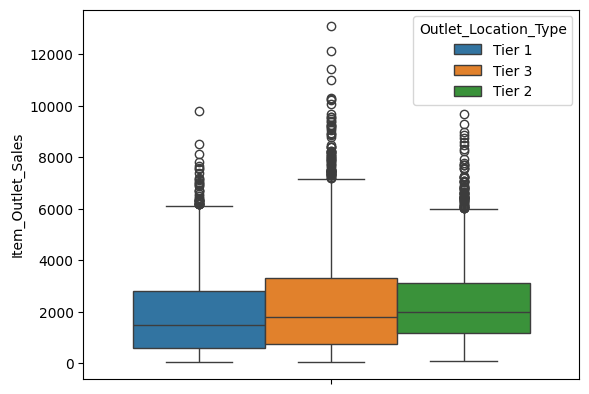

In [39]:
sns.boxplot(y="Item_Outlet_Sales", hue="Outlet_Location_Type", data=data)
plt.show()

#### Outlet_Type

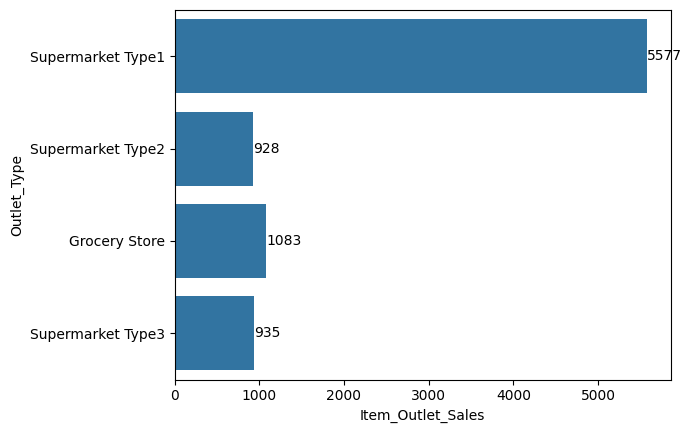

In [40]:
ax = sns.barplot(data, x="Item_Outlet_Sales", y="Outlet_Type", estimator="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);

In [41]:
# each category has different sales mean rate, so there is no need to combine them
data.groupby("Outlet_Type")["Item_Outlet_Sales"].mean()

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

#### Correlations

In [42]:
print(data.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Outlet_Sales_log',
       'Item_Identifier_trunc', 'Item_Weight_filled_median',
       'Item_Weight_filled_by_type', 'Item_Weight_filled_by_id',
       'Item_Visibility_nozeros', 'Item_Visibility_nozeros_log',
       'Item_MRP_log', 'Item_MRP_cats', 'MRP48_simil', 'MRP103_simil',
       'MRP170_simil', 'MRP240_simil', 'Outlet_Size_filled_mode'],
      dtype='object')


In [43]:
data.corr(numeric_only=True)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Outlet_Sales_log,Item_Weight_filled_median,Item_Weight_filled_by_type,Item_Weight_filled_by_id,Item_Visibility_nozeros,Item_Visibility_nozeros_log,Item_MRP_log,MRP48_simil,MRP103_simil,MRP170_simil,MRP240_simil
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123,0.009776,1.000000,1.000000,1.000000,-0.021385,-0.017832,0.025214,-0.001471,-0.031432,0.016014,0.018766
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625,-0.192996,-0.014168,-0.013384,-0.009173,0.944846,0.849380,-0.007325,0.014320,-0.002418,0.009841,0.000345
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574,0.509886,0.024951,0.026537,0.025975,-0.004525,0.001238,0.964473,-0.593607,-0.359419,0.288618,0.618400
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135,0.077032,0.007739,0.007724,-0.013426,-0.075175,-0.048720,0.004424,-0.003426,0.001960,-0.005615,0.007124
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000,0.861762,0.009693,0.010188,0.013168,-0.128449,-0.091770,0.548716,-0.340008,-0.205369,0.172225,0.355236
Item_Outlet_Sales_log,0.009776,-0.192996,0.509886,0.077032,0.861762,1.000000,0.009716,0.009128,0.007677,-0.193714,-0.141092,0.530306,-0.393941,-0.111550,0.191276,0.260333
Item_Weight_filled_median,1.000000,-0.014168,0.024951,0.007739,0.009693,0.009716,1.000000,0.996666,0.909388,-0.020441,-0.017411,0.023109,-0.001531,-0.028509,0.014244,0.017529
Item_Weight_filled_by_type,1.000000,-0.013384,0.026537,0.007724,0.010188,0.009128,0.996666,1.000000,0.910570,-0.019902,-0.017303,0.024565,-0.002251,-0.028971,0.013238,0.019093
Item_Weight_filled_by_id,1.000000,-0.009173,0.025975,-0.013426,0.013168,0.007677,0.909388,0.910570,1.000000,-0.017872,-0.015404,0.024376,-0.006121,-0.030977,0.015025,0.015836
Item_Visibility_nozeros,-0.021385,0.944846,-0.004525,-0.075175,-0.128449,-0.193714,-0.020441,-0.019902,-0.017872,1.000000,0.907913,-0.011647,0.021382,-0.004534,0.006047,-0.001428


1. Log transformation applied to the target variable introduces stronger correlation with the Item_Weight variable and some engineered features like RBF kernel Item_MRP transformation.
2. Imputation of the Item_Weight feature using a median weight value doesn't change the correlation, unlike other methods, like imputing with median value of the Item_Identifier or Item_Type group.
3. Replacing zero Item_Visibility also shows some potential in increasing correlation.
4. Applying log transformation to the Item_MRP and Item_Visibility shows a small drop in correlation.

## Training Pipeline

In [43]:
# split features from labels
X = dataset.drop("Item_Outlet_Sales", axis=1)
y = dataset.loc[:, "Item_Outlet_Sales"]

In [48]:
# define auxiliary features transformation functions 
# add variable indicating that the weight value was imputed
def add_indictor_var(X):
    # create indicator variable to mark the imputed weight values
    is_imputed = X.isna()
    return is_imputed

# Item fat content: update categories to include non-food item fat content category 
def update_fat_cats(X):
    X.loc[(X["Item_Identifier"].str[:2] == "NC"), "Item_Fat_Content"] = "Non-Consumable"
    X.loc[:, "Item_Fat_Content"].replace({"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"})
    return X[["Item_Fat_Content"]].values

def fat_name(function_transformer, feature_names_in):
    return ["Item_Fat_Content"]

# Item MRP: manually discretize variable based on its distribution analysis
def discr(X):
    # discretize MRP values
    return pd.cut(X.values.ravel(), bins=[0, 70, 136, 203, 300], labels=[1, 2, 3, 4]).reshape(-1, 1)

# Item Visibility: treat zero values as missing data, impute with item identifier group mean
def fill_visibility_zeros(X):
    # dictionary to get values to fill NaNs
    fill_dict = X.groupby("Item_Identifier")["Item_Visibility"].agg(["mean"]).to_dict()
    X["Item_Visibility"] = np.where(X["Item_Visibility"] == 0.0, np.nan, X["Item_Visibility"])
    # fill NaNs
    X["Item_Visibility"] = X["Item_Visibility"].fillna(X["Item_Identifier"].map(fill_dict["mean"]))
    return X[["Item_Visibility"]].values

def fill_visibility_name(function_transformer, feature_names_in):
    return ["Item_Visibility"]

# Outlet_Size: impute missing data with a mode value of the corresponding outlet type items group 
def fill_outlet_size(X):
    grouped_mode = X.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "Medium").to_dict()
    X["Outlet_Size"] = X["Outlet_Size"].fillna(X["Outlet_Type"].map(grouped_mode))
    return X[["Outlet_Size"]].values

def fill_outlet_size_name(function_transformer, feature_names_in):
    return ["Outlet_Size"]

# Item_Identifier: reduce the number of item categories by truncating each identifier to include only the first 3 characters
def group_item_id(X):
    X["Item_Identifier"] = X["Item_Identifier"].str[:3]
    return X

# default categorical encoding
cat_transform = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

# ordinal encoding
ordinal_enc = make_pipeline(
    OrdinalEncoder()
)

# log transformation (accepts zeros values)
log_transform = make_pipeline(
    FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out="one-to-one"),
)

# impute and encode outlet size
out_size_transform = make_pipeline(
    FunctionTransformer(fill_outlet_size, feature_names_out=fill_outlet_size_name, validate=False),
    cat_transform
)

# transform item visibility
vis_tranform = make_pipeline(
    FunctionTransformer(fill_visibility_zeros, feature_names_out=fill_visibility_name, validate=False),
)

# add indicator variables
indicator_var = make_pipeline(
    FunctionTransformer(add_indictor_var, feature_names_out="one-to-one")
)

# update fat content categories
fat_cont_trans = make_pipeline(
    FunctionTransformer(update_fat_cats, feature_names_out=fat_name, validate=False),
    cat_transform
)

# discretize and encode item mrp values
discr_pipeline = make_pipeline(
    FunctionTransformer(discr, feature_names_out="one-to-one"),
    ordinal_enc
)

# add RBF features computed based on item MRP
rbf_1 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[48]], gamma=0.006), feature_names_out="one-to-one")
)

rbf_2 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[103]], gamma=0.0025), feature_names_out="one-to-one")
)

rbf_3 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[170]], gamma=0.0025), feature_names_out="one-to-one")
)

rbf_4 = make_pipeline(
    FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[240]], gamma=0.0025), feature_names_out="one-to-one")
)

# item weight: fill with median item weight value
weight_impute = make_pipeline(
    SimpleImputer(strategy="median"),
    log_transform
)

# truncate item identifiers
trunc_id = make_pipeline(
    FunctionTransformer(group_item_id, feature_names_out="one-to-one"),
    cat_transform
)

# apply log transformation before adding polynomials
log_poly = make_pipeline(
    log_transform,
    PolynomialFeatures(2)
)

# target values transformer
target_transformer = make_pipeline(
    FunctionTransformer(np.log1p, inverse_func=np.expm1),
)

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("imputed", weight_impute, ["Item_Weight"]),
        ("size_imputed", out_size_transform, ["Outlet_Type", "Outlet_Size"]),
        ("indicator_weight", indicator_var, ["Item_Weight"]),
        ("indicator_type", indicator_var, ["Outlet_Size"]),
        ("vis_zeros", vis_tranform, ["Item_Identifier", "Item_Visibility"]),
        ("updated_cats", fat_cont_trans, ["Item_Identifier", "Item_Fat_Content"]),
        ("discrete", discr_pipeline, ["Item_MRP"]),
        ("trunc", trunc_id, ["Item_Identifier"]),
        ("rbf_50", rbf_1, ["Item_MRP"]),
        ("rbf_105", rbf_2, ["Item_MRP"]),
        ("rbf_170", rbf_3, ["Item_MRP"]),
        ("rbf_240", rbf_4, ["Item_MRP"]),
        ("log_poly", log_poly, ["Item_MRP"]),
        ("poly", PolynomialFeatures(2), ["Item_Visibility"]),
        ("ordinal", ordinal_enc, ["Outlet_Establishment_Year"]),
        ("ohe", cat_transform, ["Item_Type", "Outlet_Identifier", "Outlet_Location_Type", "Outlet_Type"]),
    ],
    remainder="passthrough"
)

# test the pipeline
X_tr = pd.DataFrame(preprocessor.fit_transform(X), columns=preprocessor.get_feature_names_out())
X_tr

,imputed__Item_Weight,size_imputed__Outlet_Size_High,size_imputed__Outlet_Size_Medium,size_imputed__Outlet_Size_Small,indicator_weight__Item_Weight,indicator_type__Outlet_Size,vis_zeros__Item_Visibility,updated_cats__Item_Fat_Content_LF,updated_cats__Item_Fat_Content_Low Fat,updated_cats__Item_Fat_Content_Non-Consumable,...,ohe__Outlet_Identifier_OUT045,ohe__Outlet_Identifier_OUT046,ohe__Outlet_Identifier_OUT049,ohe__Outlet_Location_Type_Tier 1,ohe__Outlet_Location_Type_Tier 2,ohe__Outlet_Location_Type_Tier 3,ohe__Outlet_Type_Grocery Store,ohe__Outlet_Type_Supermarket Type1,ohe__Outlet_Type_Supermarket Type2,ohe__Outlet_Type_Supermarket Type3
0,2.332144,0.0,1.0,0.0,0.0,0.0,0.016047,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.934416,0.0,1.0,0.0,0.0,0.0,0.019278,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,2.917771,0.0,1.0,0.0,0.0,0.0,0.016760,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3.005683,0.0,0.0,1.0,0.0,1.0,0.015274,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2.295560,1.0,0.0,0.0,0.0,0.0,0.008082,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,2.062423,1.0,0.0,0.0,0.0,0.0,0.056783,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8519,2.238580,0.0,0.0,1.0,0.0,1.0,0.046982,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8520,2.451005,0.0,0.0,1.0,0.0,0.0,0.035186,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8521,2.105353,0.0,1.0,0.0,0.0,0.0,0.145221,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [49]:
# test training pipeline
model = TransformedTargetRegressor(XGBRegressor(tree_method="hist", random_state=42), 
                               transformer=target_transformer)
xgb = make_pipeline(preprocessor, model)
scores = cross_validate(xgb, X, y, scoring=("neg_root_mean_squared_log_error", "neg_root_mean_squared_error", "r2"), return_train_score=True, cv=20)

print("RMSLE (train/val) mean:", -np.mean(scores["train_neg_root_mean_squared_log_error"]), -np.mean(scores["test_neg_root_mean_squared_log_error"]))
print("RMSE (train/val): mean:", -np.mean(scores["train_neg_root_mean_squared_error"]), -np.mean(scores["test_neg_root_mean_squared_error"]))
print("R-squared (train/val): mean:", np.mean(scores["train_r2"]), np.mean(scores["test_r2"]))

RMSLE (train/val) mean: 0.3521660177459397 0.5572402561234476
RMSE (train/val): mean: 810.543257290972 1189.9555276641522
R-squared (train/val): mean: 0.7743560428097209 0.5101565493680409


## Feature Selection & Hyperparameters Tuning

In [50]:
# fit xgb regressor to the transformed dataset
y_tr = target_transformer.fit_transform(y.values.reshape(-1, 1))
xgb[-1].regressor.fit(X_tr, y_tr)

# get XGB model feature importance rates
f_i = xgb[-1].regressor.feature_importances_
f_import = pd.DataFrame(f_i, index=preprocessor.get_feature_names_out(), columns=["importance"])
print("Top 15 most important features for XGB regressor:\n\n", f_import["importance"].sort_values(ascending=False)[:15])

Top 15 most important features for XGB regressor:

 ohe__Outlet_Type_Grocery Store    0.734085
log_poly__Item_MRP                0.059532
rbf_240__Item_MRP                 0.036589
indicator_weight__Item_Weight     0.019879
rbf_105__Item_MRP                 0.006543
discrete__Item_MRP                0.003351
trunc__Item_Identifier_NCG        0.003027
rbf_50__Item_MRP                  0.002914
trunc__Item_Identifier_DRB        0.002866
trunc__Item_Identifier_NCF        0.002473
trunc__Item_Identifier_DRH        0.002416
ohe__Item_Type_Breakfast          0.002182
trunc__Item_Identifier_FDZ        0.002141
trunc__Item_Identifier_NCR        0.002104
trunc__Item_Identifier_DRF        0.002038
Name: importance, dtype: float32


### XGBRegressor

In [51]:
# number of features in the preprocessed dataset 
n_features = len(preprocessor.get_feature_names_out()) + 1

# define model and include it into a pipeline with feature selection
model = TransformedTargetRegressor(XGBRegressor(tree_method="hist", random_state=42), 
                               transformer=target_transformer)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression)), 
    ('regressor', model)
])

# grid search 
param_grid = {
    'feature_selection__k': range(1, n_features) 
}
grid_search = GridSearchCV(pipeline, param_grid, cv=8, scoring="neg_root_mean_squared_log_error", n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score (RMSLE): {grid_search.best_score_}')

# evaluate 
scores = cross_validate(grid_search.best_estimator_, X, y, 
                        scoring=("neg_root_mean_squared_log_error", "neg_root_mean_squared_error", "r2"), 
                        return_train_score=True, cv=20)

print("RMSLE (train/val) mean:", -np.mean(scores["train_neg_root_mean_squared_log_error"]), -np.mean(scores["test_neg_root_mean_squared_log_error"]))
print("RMSE (train/val): mean:", -np.mean(scores["train_neg_root_mean_squared_error"]), -np.mean(scores["test_neg_root_mean_squared_error"]))
print("R-squared (train/val): mean:", np.mean(scores["train_r2"]), np.mean(scores["test_r2"]))

Best parameters: {'feature_selection__k': 10}
Best cross-validation score (RMSLE): -0.5430000207145121
RMSLE (train/val) mean: 0.47540339373817203 0.5424289122770869
RMSE (train/val): mean: 1040.1657382865246 1155.1350366755546
R-squared (train/val): mean: 0.6284122256664049 0.5381448695267552


In [52]:
# selected features names
grid_search.best_estimator_.fit(X, y)
grid_search.best_estimator_["feature_selection"].feature_names_in_=preprocessor.get_feature_names_out()
grid_search.best_estimator_["feature_selection"].get_feature_names_out()

array(['discrete__Item_MRP', 'rbf_50__Item_MRP', 'rbf_240__Item_MRP',
       'log_poly__Item_MRP', 'log_poly__Item_MRP^2',
       'ohe__Outlet_Identifier_OUT010', 'ohe__Outlet_Identifier_OUT019',
       'ohe__Outlet_Identifier_OUT027', 'ohe__Outlet_Type_Grocery Store',
       'ohe__Outlet_Type_Supermarket Type3'], dtype=object)

In [53]:
# define a pipeline
model = TransformedTargetRegressor(XGBRegressor(tree_method="hist", random_state=42), 
                               transformer=target_transformer)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),  
    ('regressor', model)
])

# grid search
param_grid = {
    "regressor__regressor__n_estimators": range(50, 250, 50),
    "regressor__regressor__learning_rate": [0.01, 0.1, 0.2],
    "regressor__regressor__max_depth": range(2, 5, 1),
    "regressor__regressor__max_leaves": [2, 3, 4],
    "regressor__regressor__min_child_weight": [0.05, 0.01, 0.1],
    "regressor__regressor__subsample": [0.6, 0.7, 0.9, 1.0],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=8, scoring="neg_root_mean_squared_log_error", n_jobs=-1)
grid_search.fit(X, y)

# best params and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score (RMSLE): {grid_search.best_score_}')

scores = cross_validate(grid_search.best_estimator_, X, y, 
                        scoring=("neg_root_mean_squared_log_error", "neg_root_mean_squared_error", "r2"), 
                        return_train_score=True, cv=20)

print("RMSLE (train/val) mean:", -np.mean(scores["train_neg_root_mean_squared_log_error"]), -np.mean(scores["test_neg_root_mean_squared_log_error"]))
print("RMSE (train/val): mean:", -np.mean(scores["train_neg_root_mean_squared_error"]), -np.mean(scores["test_neg_root_mean_squared_error"]))
print("R-squared (train/val): mean:", np.mean(scores["train_r2"]), np.mean(scores["test_r2"]))

Best parameters: {'regressor__regressor__learning_rate': 0.1, 'regressor__regressor__max_depth': 2, 'regressor__regressor__max_leaves': 2, 'regressor__regressor__min_child_weight': 0.05, 'regressor__regressor__n_estimators': 200, 'regressor__regressor__subsample': 0.7}
Best cross-validation score (RMSLE): -0.5213479398801035
RMSLE (train/val) mean: 0.5176886603164397 0.5206777098861732
RMSE (train/val): mean: 1103.652249579374 1108.5617635283727
R-squared (train/val): mean: 0.5816746745376699 0.5751547225176693


### LinearRegression

In [54]:
# define model and include it into a pipeline with feature selection
model = TransformedTargetRegressor(LinearRegression(), 
                               transformer=target_transformer)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression)), 
    ('regressor', model)
])

# grid search 
param_grid = {
    'feature_selection__k': range(1, n_features) 
}
grid_search = GridSearchCV(pipeline, param_grid, cv=8, scoring="neg_root_mean_squared_log_error", n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score (RMSLE): {grid_search.best_score_}')

# evaluate 
scores = cross_validate(grid_search.best_estimator_, X, y, 
                        scoring=("neg_root_mean_squared_log_error", "neg_root_mean_squared_error", "r2"), 
                        return_train_score=True, cv=20)

print("RMSLE (train/val) mean:", -np.mean(scores["train_neg_root_mean_squared_log_error"]), -np.mean(scores["test_neg_root_mean_squared_log_error"]))
print("RMSE (train/val): mean:", -np.mean(scores["train_neg_root_mean_squared_error"]), -np.mean(scores["test_neg_root_mean_squared_error"]))
print("R-squared (train/val): mean:", np.mean(scores["train_r2"]), np.mean(scores["test_r2"]))

Best parameters: {'feature_selection__k': 21}
Best cross-validation score (RMSLE): -0.5170992269999103
RMSLE (train/val) mean: 0.5160267161825158 0.5167829192070037
RMSE (train/val): mean: 1100.6788993432856 1102.6048800416652
R-squared (train/val): mean: 0.5839258012865322 0.5796027286189537


In [55]:
# selected feature names
grid_search.best_estimator_.fit(X, y)
grid_search.best_estimator_["feature_selection"].feature_names_in_=preprocessor.get_feature_names_out()
grid_search.best_estimator_["feature_selection"].get_feature_names_out()

array(['size_imputed__Outlet_Size_Medium',
       'size_imputed__Outlet_Size_Small', 'indicator_weight__Item_Weight',
       'indicator_type__Outlet_Size', 'vis_zeros__Item_Visibility',
       'discrete__Item_MRP', 'rbf_50__Item_MRP', 'rbf_105__Item_MRP',
       'rbf_170__Item_MRP', 'rbf_240__Item_MRP', 'log_poly__Item_MRP',
       'log_poly__Item_MRP^2', 'poly__Item_Visibility',
       'poly__Item_Visibility^2', 'ohe__Outlet_Identifier_OUT010',
       'ohe__Outlet_Identifier_OUT019', 'ohe__Outlet_Identifier_OUT027',
       'ohe__Outlet_Location_Type_Tier 1',
       'ohe__Outlet_Type_Grocery Store',
       'ohe__Outlet_Type_Supermarket Type1',
       'ohe__Outlet_Type_Supermarket Type3'], dtype=object)

### Voting

In [56]:
model_1 = TransformedTargetRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=2, max_leaves=2,
                                                  subsample=0.7, min_child_weight=0.05, random_state=42),
                               transformer=target_transformer)

model_2 = TransformedTargetRegressor(LinearRegression(), 
                               transformer=target_transformer)

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),  
    ('regressor', model_1)
])

pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=21)),  
    ('regressor', model_2)
])

voting = VotingRegressor(estimators=[
    ('xgb', pipeline_1), 
    ('lr', pipeline_2)])

voting_pipeline = make_pipeline(voting)

scores = cross_validate(voting_pipeline, X, y, 
                        scoring=("neg_root_mean_squared_log_error", "neg_root_mean_squared_error", "r2"), 
                        return_train_score=True, cv=20)

print("RMSLE (train/val) mean:", -np.mean(scores["train_neg_root_mean_squared_log_error"]), -np.mean(scores["test_neg_root_mean_squared_log_error"]))
print("RMSE (train/val): mean:", -np.mean(scores["train_neg_root_mean_squared_error"]), -np.mean(scores["test_neg_root_mean_squared_error"]))
print("R-squared (train/val): mean:", np.mean(scores["train_r2"]), np.mean(scores["test_r2"]))

RMSLE (train/val) mean: 0.5157543160219125 0.5176402869504372
RMSE (train/val): mean: 1099.7779886745018 1103.259378478345
R-squared (train/val): mean: 0.5846065246317572 0.5791688611138717


### Stacking

In [57]:
model_1 = TransformedTargetRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=2, max_leaves=2,
                                                  subsample=0.7, min_child_weight=0.05, random_state=42),
                               transformer=target_transformer)

model_2 = TransformedTargetRegressor(LinearRegression(), 
                               transformer=target_transformer)

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),  
    ('regressor', model_1)
])

pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=21)),  
    ('regressor', model_2)
])

reg = StackingRegressor(
    estimators=[
        ('xgb', pipeline_1), 
        ('lr', pipeline_2)],
    final_estimator=LinearRegression()
)

voting_pipeline = make_pipeline(reg)

scores = cross_validate(voting_pipeline, X, y, 
                        scoring=("neg_root_mean_squared_log_error", "neg_root_mean_squared_error", "r2"), 
                        return_train_score=True, cv=20)

print("RMSLE (train/val) mean:", -np.mean(scores["train_neg_root_mean_squared_log_error"]), -np.mean(scores["test_neg_root_mean_squared_log_error"]))
print("RMSE (train/val): mean:", -np.mean(scores["train_neg_root_mean_squared_error"]), -np.mean(scores["test_neg_root_mean_squared_error"]))
print("R-squared (train/val): mean:", np.mean(scores["train_r2"]), np.mean(scores["test_r2"]))

RMSLE (train/val) mean: 0.5403426316446497 0.5411701076795807
RMSE (train/val): mean: 1071.4822412444441 1074.0493868777405
R-squared (train/val): mean: 0.6057069323720425 0.6002036913459076


Stacking ensemble shows the lowest RMSE value as well as the highest proportion of data variance explained compared to individual models and voting ensemble.